
This notebook will reproduce some aspects of the paper:
An Approach of electrical load profile analysis based on time series Data Mining
Ying Shi,Tao Yu,Qianjin Liu,Hanxin Zhu,Fusheng Li,Yaxiong Wu



The authors present an approach to typical load profile extraction for a single consumer:

1. Apply Z-score
2. Data dimension-reduction using Piecwise Aggregate Approximation(PAA)
3. Load Profile re-expression using Symbolic Aggregation Approximation(SAX)
4. Extraction of Motif and Discords

In [103]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from pyts.approximation import PiecewiseAggregateApproximation
import matplotlib.pyplot as plt
from pyts.approximation import SymbolicAggregateApproximation
from scipy.stats import norm
import matplotlib.lines as mlines
from collections import Counter

In [3]:
os.getcwd()

'/home/usman/Documents/Smart-Meter-analysis/Approach of Electrical Load Profile Analysis based on Time Series Data Mining'

In [6]:
# Use sample time series profile 

df = pd.read_csv('/home/usman/Documents/Smart-Meter-analysis/total_hhblock.csv')

In [7]:
df.shape

(3469352, 51)

In [9]:
df = df.iloc[:,1:]

In [10]:
df = df[df.LCLid == 'MAC000742']

In [11]:
df.shape

(674, 50)

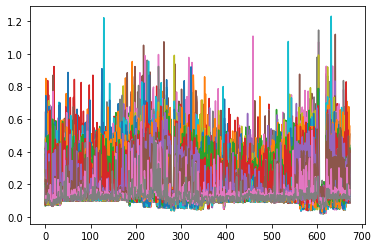

In [158]:
plt.plot(df.iloc[:,2:])

### Remove outliers

In [18]:
df.isna().sum()
# we have a single na in the 30. 
df = df.dropna()

### Apply Z-Score

In [26]:
scaler = StandardScaler()
df_ = scaler.fit_transform(df.iloc[:,2:])

In [30]:
df_.shape

(673, 48)

### Data Dimension reduction using PAA

In [64]:
# windows size is a hyper-paramter which can be tuned
# In this example, for a 48 timestep (24hour period), we are using a window size of 8, following the hp of the paper

n_samples, n_timestamps = df_.shape[0],df_.shape[1]

# PAA transformation
window_size = 8
paa = PiecewiseAggregateApproximation(window_size=window_size)
df_paa = paa.transform(df_)




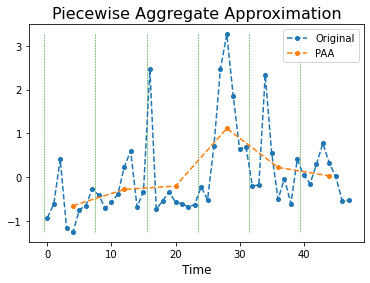

In [65]:
plt.figure(figsize=(6, 4))
plt.plot(df_[0], 'o--', ms=4, label='Original')
plt.plot(np.arange(window_size // 2,
                   n_timestamps + window_size // 2,
                   window_size), df_paa[0], 'o--', ms=4, label='PAA')
plt.vlines(np.arange(0, n_timestamps, window_size) - 0.5,
           df_[0].min(), df_[0].max(), color='g', linestyles='--', linewidth=0.5)
plt.legend(loc='best', fontsize=10)
plt.xlabel('Time', fontsize=12)
plt.title('Piecewise Aggregate Approximation', fontsize=16)
plt.show()

### Load Profile Re-expression using SAX

In [44]:
# The aim of this approach is to find Discords(infrequent load profiles) and Motifs(Common load profiles)

In [67]:
## n_bins is a hyperparamter which can be changed. The authors use a value of 4

n_bins = 4
sax = SymbolicAggregateApproximation(n_bins=n_bins, strategy='normal')
df_sax = sax.fit_transform(df_paa)


In [68]:
bins = norm.ppf(np.linspace(0, 1, n_bins + 1)[1:-1])

# Show the results for the first time series
bottom_bool = np.r_[True, df_sax[0, 1:] > df_sax[0, :-1]]

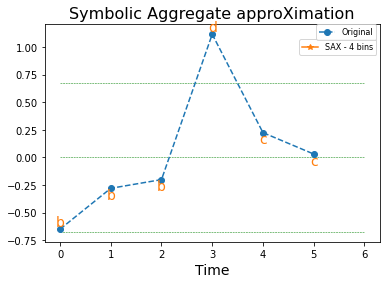

In [69]:
plt.figure(figsize=(6, 4))
plt.plot(df_paa[0], 'o--', label='Original')
for x, y, s, bottom in zip(range(df_paa[0].shape[0]), df_paa[0], df_sax[0], bottom_bool):
    va = 'bottom' if bottom else 'top'
    plt.text(x, y, s, ha='center', va=va, fontsize=14, color='#ff7f0e')
plt.hlines(bins, 0, df_paa[0].shape[0], color='g', linestyles='--', linewidth=0.5)
sax_legend = mlines.Line2D([], [], color='#ff7f0e', marker='*',
                           label='SAX - {0} bins'.format(n_bins))
first_legend = plt.legend(handles=[sax_legend], fontsize=8, loc=(0.76, 0.86))
ax = plt.gca().add_artist(first_legend)
plt.legend(loc=(0.81, 0.93), fontsize=8)
plt.xlabel('Time', fontsize=14)
plt.title('Symbolic Aggregate approXimation', fontsize=16)
plt.show()

### Extraction of Motifs and Discords: Sankey Diagram

In [71]:
#In order to do this we need to calculate counts of moving from one 'state' to another
# or we can just groupby

In [101]:
df_sax_ = []
for x in df_sax:
    df_sax_.append(''.join(map(str, x)))

In [105]:
df_sax_occurs = Counter(df_sax_)

In [201]:
use_sax = df_sax_occurs.most_common()[:9]

['c', 'c', 'b', 'b', 'b', 'b']

In [203]:
use_sax_ = [list(x[0]) for x in use_sax]

In [133]:
get_tlp = pd.DataFrame(df_sax_,columns = ['sax'])

In [204]:
use_sax = [x[0] for x in use_sax]

In [140]:
sax_locs = []
for x in use_sax:
    locs_ = get_tlp[get_tlp['sax'] == x]
    sax_locs.append(locs_)

In [163]:
# now we have the indices, we can view the profiles
sax_index = [x.index.to_list() for x in sax_locs]
sax_flat_index = [item for sublist in sax_index for item in sublist]

In [165]:
df_tfp = df.loc[sax_flat_index]

In [178]:
df_tfp.iloc[0,2:].shape

(48,)

In [172]:
x = np.linspace(0,47,48)

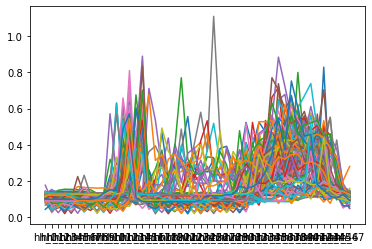

In [184]:
for i in range(df_tfp.shape[0]):
    plt.plot(df_tfp.iloc[i,2:])

In [188]:
TLP = df_tfp.iloc[:,2:].mean()

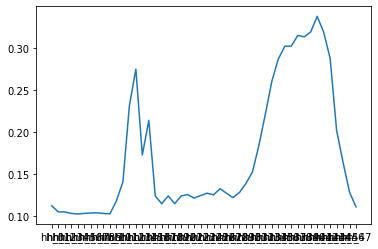

In [190]:
plt.plot(TLP)

In [216]:
TLP

hh_0     0.112779
hh_1     0.105459
hh_2     0.105410
hh_3     0.103623
hh_4     0.102885
hh_5     0.103582
hh_6     0.104115
hh_7     0.104246
hh_8     0.103574
hh_9     0.103131
hh_10    0.118557
hh_11    0.141008
hh_12    0.231598
hh_13    0.275041
hh_14    0.173041
hh_15    0.214189
hh_16    0.124180
hh_17    0.115139
hh_18    0.124418
hh_19    0.115180
hh_20    0.124320
hh_21    0.126016
hh_22    0.121836
hh_23    0.124811
hh_24    0.127672
hh_25    0.125697
hh_26    0.132943
hh_27    0.127582
hh_28    0.122361
hh_29    0.128467
hh_30    0.139238
hh_31    0.152746
hh_32    0.184393
hh_33    0.221689
hh_34    0.260672
hh_35    0.287148
hh_36    0.302295
hh_37    0.302459
hh_38    0.315139
hh_39    0.313418
hh_40    0.319262
hh_41    0.337828
hh_42    0.319098
hh_43    0.287844
hh_44    0.202336
hh_45    0.164164
hh_46    0.128639
hh_47    0.111369
dtype: float64